In [1]:
import torch
from torch import nn
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Globally disable gradient calculations, since we're only gonna be doing
# predictions in this notebook
torch.set_grad_enabled(False)

In [2]:
bg_files = glob.glob('images/char-bgs/*.png')
puyo_files = glob.glob('images/puyo-skins/*.png')
bg_images = [np.array(Image.open(f).crop((8, 2, 392, 722))) for f in bg_files]
puyo_skins = [np.array(Image.open(f)) for f in puyo_files]

## Helper Functions

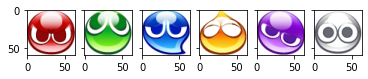

In [3]:
def get_cropped_puyos(puyo_skin: np.ndarray):
    puyos = []

    # Get colored Puyos
    for y in range(0, 72 * 5, 72):
        y0, y1 = y, y + 60
        color = []
        for x in np.arange(0, 72 * 16, 72):
            x0, x1 = x, x + 64
            color.append(puyo_skin[y0:y1, x0:x1, :])
        puyos.append(color)
    
    # Get Garbage Puyos
    y0, y1 = 72, 72 + 60
    color = []
    for x in np.arange(18 * 72, 21 * 72, 72):
        x0, x1 = x, x + 64
        color.append(puyo_skin[y0:y1, x0:x1, :])
    puyos.append(color)

    return puyos

# Test
puyos = get_cropped_puyos(puyo_skins[0])
fig, ax = plt.subplots(1, 6, sharey=True)
for i in range(len(puyos)):
    ax[i].imshow(puyos[i][0])
plt.show()

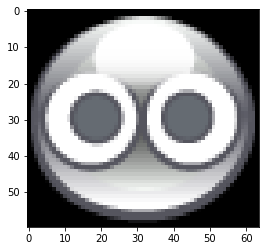

In [4]:
def alpha_blend(bg: np.ndarray, top: np.ndarray):
    '''
    https://en.wikipedia.org/wiki/Alpha_compositing#Alpha_blending
    '''
    # # Fix alpha=0 in top layer.
    # top[:, :, :3][top[:, :, 3] == 0] = 0
    
    bg = bg.astype(np.float32) / 255.0
    top = top.astype(np.float32) / 255.0
    a = top[:, :, 3]
    a = a[:, :, np.newaxis] * np.array([1, 1, 1])
    top_rgb = top[:, :, :3]
    return np.array((top_rgb * a + bg[:, :, :3] * (1 - a)) * 255, dtype=np.uint8)

test_bg = np.ones((60, 64, 4), dtype=np.uint8) * np.array([0, 0, 0, 255])
test_im = puyos[5][0]
im_a = alpha_blend(test_bg, test_im)
plt.imshow(im_a)
plt.show()

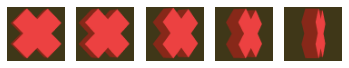

In [5]:
def get_X(char_bg: np.ndarray, puyo_skin: np.ndarray):
    # Get the spinning X
    y0, y1 = 72 * 11, 72 * 11 + 60
    spinning_Xes = []
    for x in np.arange(5 * 72, 10 * 72, 72):
        x0, x1 = x, x + 64
        spinning_Xes.append(puyo_skin[y0:y1, x0:x1, :])

    # Get mean color of char_bg
    mean_color = np.mean(char_bg.reshape(-1, 4), axis=0)
    mean_color = np.array(mean_color, dtype=np.uint8)

    cell = np.ones((60, 64, 4), dtype=np.uint8) * mean_color
    cells = []

    for spinner in spinning_Xes:
        cells.append(alpha_blend(cell, spinner))
    
    return cells

Xes = get_X(bg_images[0], puyo_skins[0])
fig, ax = plt.subplots(1, len(Xes))
for x in range(len(Xes)):
    ax[x].imshow(Xes[x])
    ax[x].axis('off')
plt.show()

## Load PyTorch Model

In [23]:
class PuyoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), # -> [-1, 16, 28, 30]
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # -> [-1, 16, 14, 15]
            nn.Conv2d(16, 32, kernel_size=3), # -> [-1, 16, 12, 13]
            nn.ReLU(),
            nn.Conv2d(32, 10, kernel_size=3), # -> [-1, 10, 10, 11]
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(10 * 10 * 11, 100),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(100, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 6),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 10 * 10 * 11)
        x = self.fc(x)
        return x

model = PuyoClassifier()
model.load_state_dict(torch.load('puyo-classifier.pt'))
model.to(device)
model.eval()

PuyoClassifier(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=100, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=6, bias=True)
    (8): ReLU()
  )
)

In [52]:
classes = ['blue', 'garbage', 'green', 'purple', 'red', 'yellow']

In [24]:
# Set up image input transformer
trsfm = transforms.Compose([
    transforms.Resize((30, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

## Test a Classification

In [25]:
test_puyos = {
    'garbage': [],
    'red': [],
    'green': [],
    'blue': [],
    'yellow': [],
    'purple': []
}

for puyo_skin in puyo_skins:
    puyos = get_cropped_puyos(puyo_skin)

    for row, color in zip(puyos, ['red', 'green', 'blue', 'yellow', 'purple', 'garbage']):
        test_puyos[color].append(row[0])

print({k: len(test_puyos[k]) for k in test_puyos})

{'garbage': 14, 'red': 14, 'green': 14, 'blue': 14, 'yellow': 14, 'purple': 14}


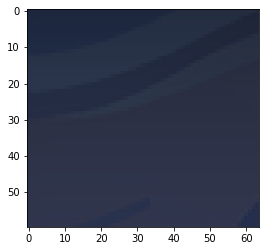

In [26]:
x = 1
y = 0
x0, x1 = x * 64, (x + 1) * 64
y0, y1 = y * 60, (y + 1) * 60
cell = bg_images[3][y0:y1, x0:x1, :]
plt.imshow(cell)
plt.show()

(60, 64, 3)


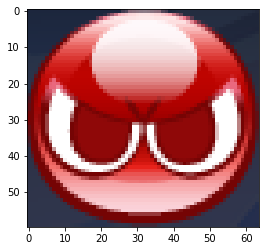

In [33]:
test_im = alpha_blend(cell, test_puyos['red'][0])
print(test_im.shape)
plt.imshow(test_im)
plt.show()

# Convert to tensor. It expects a PIL Image
test_im = Image.fromarray(test_im)
test_im = trsfm(test_im)
test_im.unsqueeze_(0)
test_im = test_im.to(device)

In [55]:
def predict(im, classes):
    pred = model(im)
    value, index = torch.max(pred,1)
    print(pred)
    return classes[index]

In [45]:
predict(test_im, classes)

tensor([[0.0000, 0.0000, 2.6103, 0.0000, 8.1593, 3.5877]], device='cuda:0')


'red'

## What happens with an empty cell...?

In [50]:
test_cell = cell[:, :, :3]

# Convert to tensor. It expects a PIL Image
cell_PIL = Image.fromarray(test_cell)
cell_tensor = trsfm(cell_PIL)
cell_tensor.unsqueeze_(0)
cell_tensor = cell_tensor.to(device)

predict(cell_tensor, classes)

tensor([[3.1311, 4.6467, 0.0771, 0.0000, 0.0000, 0.0000]], device='cuda:0')


'garbage'

I need to analyze the values in the prediction tensor to decide whether the model is actually confident that something is a Puyo.

## Try all colors...

In [58]:
for color in ['red', 'green', 'blue', 'yellow', 'purple', 'garbage']:
    print('Testing: ', color)
    test_im = alpha_blend(cell, test_puyos[color][0])

    # Convert to tensor. It expects a PIL Image
    test_im = Image.fromarray(test_im)
    test_im = trsfm(test_im)
    test_im.unsqueeze_(0)
    test_im = test_im.to(device)
    
    max_pred = predict(test_im, classes)
    print('Max Prediction: ', max_pred)
    print('----------------')

Testing:  red
tensor([[0.0000, 0.0000, 2.6103, 0.0000, 8.1593, 3.5877]], device='cuda:0')
Max Prediction:  red
----------------
Testing:  green
tensor([[0.0000, 1.0572, 6.7671, 0.0000, 2.4430, 0.0000]], device='cuda:0')
Max Prediction:  green
----------------
Testing:  blue
tensor([[14.8987,  0.0000,  0.0000,  7.5986,  0.0000,  1.8521]],
       device='cuda:0')
Max Prediction:  blue
----------------
Testing:  yellow
tensor([[ 0.0000,  0.0000,  0.0000,  2.8638,  3.8500, 11.2681]],
       device='cuda:0')
Max Prediction:  yellow
----------------
Testing:  purple
tensor([[ 5.5073,  0.0000,  0.0000, 16.2531,  0.0000,  7.0888]],
       device='cuda:0')
Max Prediction:  purple
----------------
Testing:  garbage
tensor([[0.4882, 3.0788, 1.0605, 0.0000, 0.0000, 0.0000]], device='cuda:0')
Max Prediction:  garbage
----------------


🤔 The max prediction seems to generally be at least double the 2nd prediction.

## All the Puyo Skins

In [65]:
def predict_color(im: np.ndarray, classes):
    # Convert to tensor. It expects a PIL Image
    test_im = Image.fromarray(im)
    test_im = trsfm(test_im)
    test_im.unsqueeze_(0)
    test_im = test_im.to(device)

    pred = model(test_im)
    value, index = torch.max(pred,1)
    return classes[index]

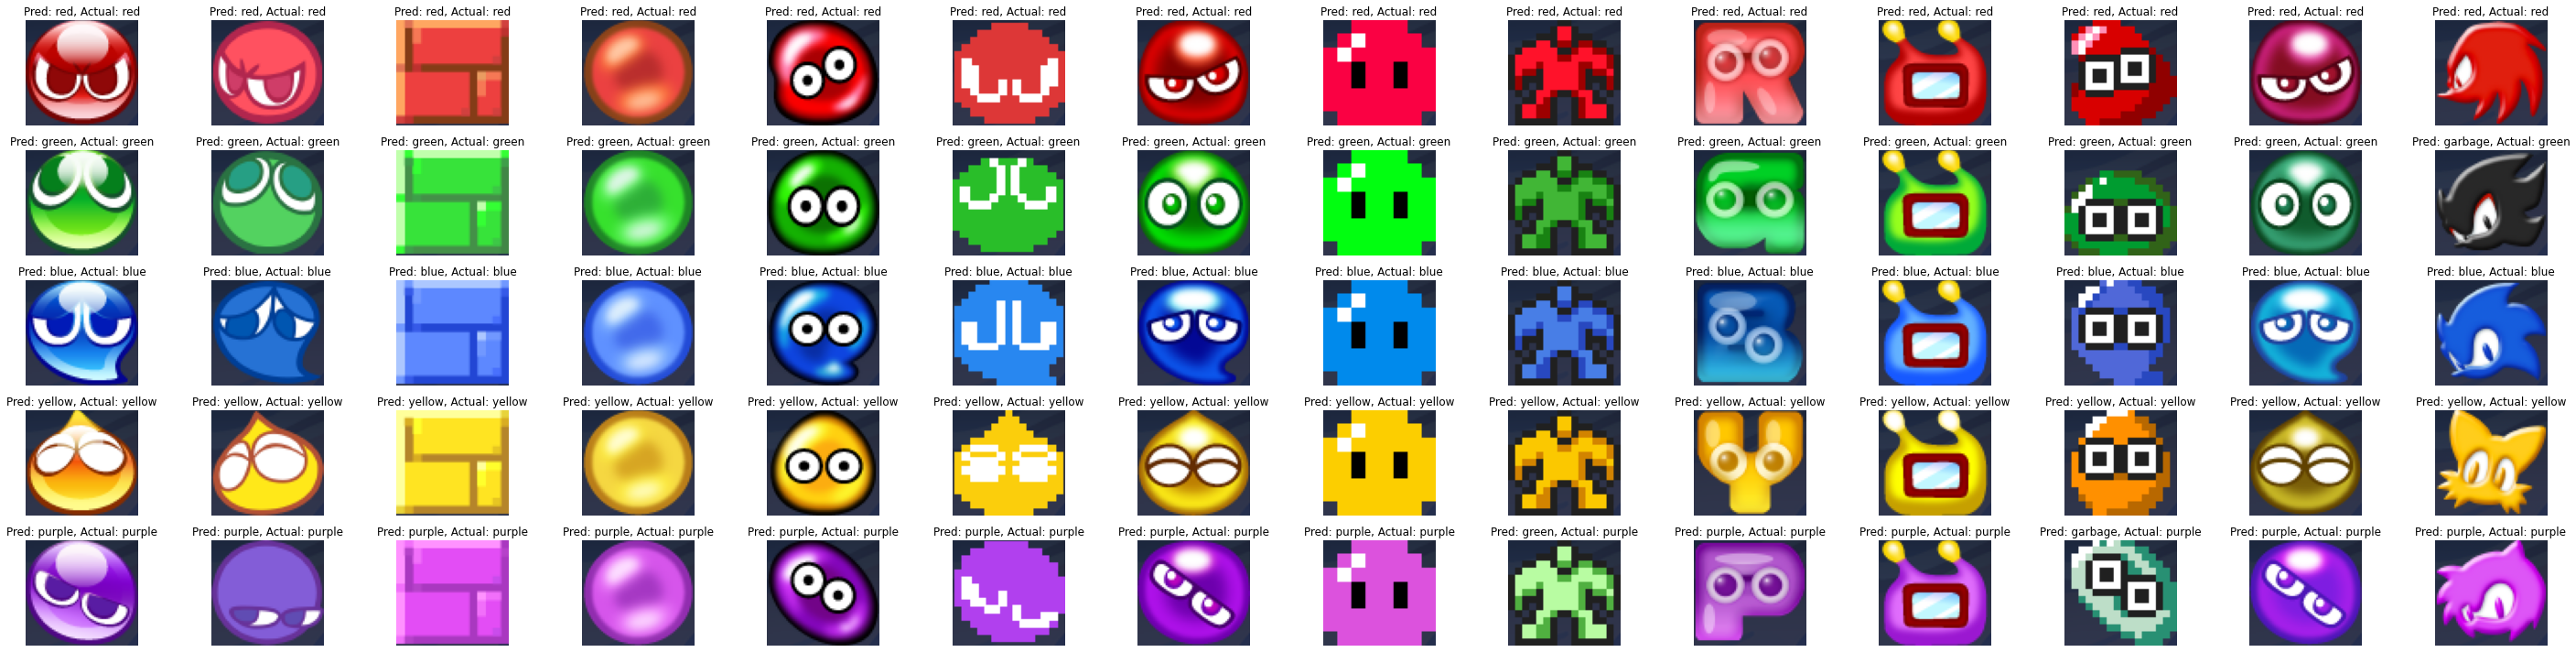

In [75]:
num_skins = len(test_puyos['red'])
fig, ax = plt.subplots(5, num_skins)
fig.set_figheight(10)
fig.set_figwidth(40)

for r, color in enumerate(['red', 'green', 'blue', 'yellow', 'purple']):
    for i, puyo in enumerate(test_puyos[color]):
        im = alpha_blend(cell, puyo)
        ax[r][i].imshow(im)
        pred = predict_color(im, classes)
        ax[r][i].set_title('Pred: {p}, Actual: {a}'.format(p = pred, a = color))
        ax[r][i].axis('off')

plt.tight_layout()
plt.show()